In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as mtick
from sklearn.metrics import mean_squared_error

In [3]:
rates=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical rates', header=1)
portfolio=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical portfolio', header=1)

In [4]:
ftp=rates.iloc[:,:6]
euribor=rates.iloc[:,7:]

In [5]:
new_column_names = {'3Y.1': '3Y', '5Y.1': '5Y', '10Y.1': '10Y'}

# Rename columns
euribor.rename(columns=new_column_names, inplace=True)

In [6]:
# Sample data setup
train_data = euribor.iloc[:96, 1:]
test_data = euribor.iloc[96:, 1:]

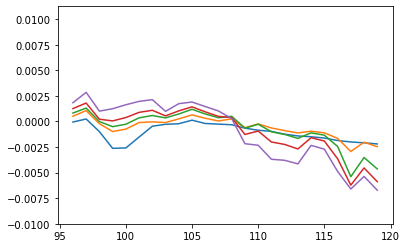

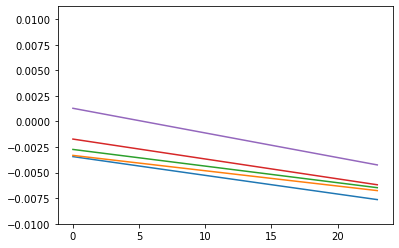

0.002137115491473829


In [71]:
n = len(test_data)
expected_forecast = np.zeros((len(test_data),5))
a_vasi_list = []
lr_mu_vasi_list = []
var_vasi_list = []

for j in range(0,5):
    dt=1/12
    a_vasi = -1 / 12 * np.log((n * sum(euribor.iloc[0: (n - 2),j+1].values * euribor.iloc[1 : (n-1), j+1].values) - sum(euribor.iloc[ 1 : (n-1),j+1].values) * sum(euribor.iloc[0: (n - 2),j+1].values))/(n * sum(euribor.iloc[0 : (n - 2),j+1]**2) - sum(euribor.iloc[0 : (n - 2),j+1])**2))
    lr_mu_vasi = 1 / (n * (1 - np.exp(-a_vasi / 12))) * (sum(euribor.iloc[1 : (n-1),j+1]) - np.exp(a_vasi / 12) * sum(euribor.iloc[0 : (n - 2),j+1]))
    var_vasi = 2 * a_vasi / (n * (1 - np.exp(-a_vasi / 6))) * sum((euribor.iloc[1 : (n-1),j+1].values - euribor.iloc[0 : (n -2),j+1].values * np.exp(-a_vasi/12) - lr_mu_vasi * (1 - np.exp(-a_vasi/12)))**2)
    
    a_vasi_list.append(a_vasi)
    lr_mu_vasi_list.append(lr_mu_vasi)
    var_vasi_list.append(var_vasi)
    
    expected_forecast[0, j] = train_data.iloc[-1,j] * np.exp(-a_vasi*dt) + lr_mu_vasi * (1 - np.exp(-a_vasi / 12))
    for i in range(1, len(test_data)):
        expected_forecast[i,j] = expected_forecast[i - 1, j] * np.exp(-a_vasi*dt) + lr_mu_vasi * (1 - np.exp(-a_vasi * dt))
    
    #expected_forecast[0,j] = train_data.iloc[- 1, j] + a_vasi * (lr_mu_vasi - train_data.iloc[- 1, j]) * dt + np.sqrt(var_vasi) * np.sqrt(dt) * np.random.randn()
    #for i in range(1, len(test_data)):
        #expected_forecast[i,j] = expected_forecast[i - 1, j] + a_vasi * (lr_mu_vasi - expected_forecast[i - 1, j]) * dt + np.sqrt(var_vasi) * np.sqrt(dt) * np.random.randn()
    
        
results_df = pd.DataFrame({
    'a_vasi': a_vasi_list,
    'lr_mu_vasi': lr_mu_vasi_list,
    'var_vasi': var_vasi_list
})        

plt.plot(expected_forecast-test_data)
plt.ylim(-0.010, 0.01125)
plt.show()

plt.plot(expected_forecast)
plt.ylim(-0.010, 0.01125)
plt.show()

expected_forecast=pd.DataFrame(expected_forecast)

# Define new column names
new_column_names = ["6M", "1Y", "3Y", "5Y", "10Y"]
expected_forecast=expected_forecast.set_index(test_data.index)
# Change column names
expected_forecast.columns = new_column_names


# Calculate RMSE

mse_vasi_paper = mean_squared_error(test_data, expected_forecast)
print(np.sqrt(mse_vasi_paper))


def Mle_Vasicek(data):
    n = len(data) - 1
    dt = 1/12  # size of each step
    parameters = np.zeros(3)
    expectedinfomatrix = np.zeros((3, 3))
    S0, S1, S00, S01 = 0, 0, 0, 0  # initialize sums
    for i in range(n):
        S0 += data[i]
        S1 += data[i + 1]
        S00 += data[i] * data[i]
        S01 += data[i] * data[i + 1]
    
    ahat = -(1 / dt) * np.log((n * S01 - S0 * S1) / (n * S00 - S0 ** 2))  # alpha-hat
    rhat = 1 / (n * (1 - np.exp(-ahat * dt))) * (S1 - np.exp(-ahat * dt) * S0)  # r-hat
    sigmapart = 0  # initialize sum for sigma estimator
    for j in range(n):
        sigmapart += (data[j + 1] - data[j] * np.exp(-ahat * dt) - rhat * (1 - np.exp(-ahat * dt)))
    #sigma2 = 2 * ahat * sigmapart / (n * (1 - np.exp(-2 * ahat * dt)))  # sigma2-hat
    sigma2 = 2 * ahat / (n * (1 - np.exp(-2* ahat * dt))) * sum((data[1:n].values - data[0:(n-1)].values * np.exp(-ahat/12) - rhat * (1 - np.exp(-ahat*dt)))**2)
    
    parameters[0] = ahat
    parameters[1] = rhat
    parameters[2] = np.sqrt(sigma2)
    lvalue = -n / 2 * np.log(sigma2 / (2 * ahat) * (1 - np.exp(-2 * ahat * dt))) - n / 2 * np.log(2 * np.pi) - (sigma2 / ahat * (1 - np.exp(-2 * ahat * dt))) ** (-1) * sigmapart
    #adresses a value to the log-likelihood based on the estimators
    return parameters, lvalue


ah_list=[]
rh_list=[]
sh_list=[]
lvalue_list=[]
for i in range(5):
    parameters, lvalue = Mle_Vasicek(train_data.iloc[:, i])
    ah = parameters[0]
    rh = parameters[1]
    sh = parameters[2]
    ah_list.append(ah)
    rh_list.append(rh)
    sh_list.append(sh)
    lvalue_list.append(lvalue)
    
para_vasi = pd.DataFrame({
    'ahat': ah_list,
    'rhat': rh_list,
    'sighat': sh_list,
    'log': lvalue_list
})  

print(para_vasi)

expected_forecast = np.zeros((len(test_data),5))
for j in range(0,5):
    dt=1/12
    expected_forecast[0, j] = train_data.iloc[-1,j] * np.exp(-ah_list[j]) + rh_list[j] * (1 - np.exp(-ah_list[j]))
    for i in range(1, len(test_data)):
        expected_forecast[i,j] = expected_forecast[i - 1, j] * np.exp(-ah_list[j]/12) + rh_list[j] * (1 - np.exp(-ah_list[j] / 12))
        
expected_forecast=pd.DataFrame(expected_forecast)

##### Define new column names
new_column_names = ["6M", "1Y", "3Y", "5Y", "10Y"]
expected_forecast=expected_forecast.set_index(test_data.index)
##### Change column names
expected_forecast.columns = new_column_names

plt.plot(test_data)
plt.ylim(-0.010, 0.01125)
plt.show()

plt.plot(expected_forecast)
plt.ylim(-0.010, 0.01125)
plt.show()

##### Calculate RMSE

mse_vasi_paper = mean_squared_error(test_data, expected_forecast)
print(np.sqrt(mse_vasi_paper)) 

In [8]:
results_df

,a_vasi,lr_mu_vasi,var_vasi
0,0.005826,-0.381799,0.000002
1,0.004928,-0.369276,0.000006
2,0.004339,-0.453869,0.000009
3,0.004044,-0.580045,0.000016
4,0.002924,-0.988825,0.000025


### Make simulations for t=1 till t=120
\begin{align}
R(t)\sim N(m(t), Var(t)),\\
m(t)= R(0)e^{-\alpha t}+r(1-e^{-\alpha t}) \\
Var(t) = \frac{\sigma^2}{2\alpha}(1-e^{-2\alpha t})
\end{align}

In [100]:
n = len(euribor)
a_vasi_list = []
lr_mu_vasi_list = []
var_vasi_list = []

for j in range(0,5):
    dt=1/12
    a_vasi = -1 / 12 * np.log((n * sum(euribor.iloc[0: (n - 2),j+1].values * euribor.iloc[1 : (n-1), j+1].values) - sum(euribor.iloc[ 1 : (n-1),j+1].values) * sum(euribor.iloc[0: (n - 2),j+1].values))/(n * sum(euribor.iloc[0 : (n - 2),j+1]**2) - sum(euribor.iloc[0 : (n - 2),j+1])**2))
    lr_mu_vasi = 1 / (n * (1 - np.exp(-a_vasi / 12))) * (sum(euribor.iloc[1 : (n-1),j+1]) - np.exp(a_vasi / 12) * sum(euribor.iloc[0 : (n - 2),j+1]))
    var_vasi = 2 * a_vasi / (n * (1 - np.exp(-a_vasi / 6))) * sum((euribor.iloc[1 : (n-1),j+1].values - euribor.iloc[0 : (n -2),j+1].values * np.exp(-a_vasi/12) - lr_mu_vasi * (1 - np.exp(-a_vasi/12)))**2)
    
    a_vasi_list.append(a_vasi)
    lr_mu_vasi_list.append(lr_mu_vasi)
    var_vasi_list.append(var_vasi)
    
        
results_df = pd.DataFrame({
    'a_vasi': a_vasi_list,
    'lr_mu_vasi': lr_mu_vasi_list,
    'var_vasi': var_vasi_list
})        
print(results_df)


     a_vasi  lr_mu_vasi  var_vasi
0  0.004868   -0.404468  0.000003
1  0.004192   -0.375159  0.000005
2  0.004077   -0.378304  0.000009
3  0.003753   -0.476681  0.000015
4  0.002750   -0.810688  0.000023


In [115]:
R0 = euribor.iloc[0,1:]
alpha = a_vasi_list
sigma = var_vasi_list
r = lr_mu_vasi_list

In [130]:
# Number of time steps
T = 120

# Initialize arrays to store simulated rates
simulated_rates = np.zeros((T, 5))

# Simulate rates for each maturity
for j in range(5):
    for t in range(0, T):
        m_t = R0[j] * np.exp(-alpha[j] * (t+1)/12) + r[j] * (1 - np.exp(-alpha[j] * (t+1)/12))
        var_t = (sigma[j] / (2 * alpha[j])) * (1 - np.exp(-2 * alpha[j] * (t+1)/12))
        simulated_rates[t , j] = np.random.normal(m_t, np.sqrt(var_t))

simulated_rates = pd.DataFrame(simulated_rates)
new_column_names = {0:'6M', 1 : '1Y', 2: '3Y', 3: '5Y', 4: '10Y'}
# Rename columns
simulated_rates.rename(columns=new_column_names, inplace=True)

# Display the simulated rates
print(simulated_rates)
simulated_rates.to_excel("simulated_vasicek.xlsx", index=True)

           6M        1Y        3Y        5Y       10Y
0    0.013311  0.010679  0.012715  0.016562  0.026656
1    0.014591  0.012201  0.011910  0.017172  0.023411
2    0.015255  0.010732  0.012837  0.015121  0.028641
3    0.013011  0.010347  0.013447  0.015229  0.026095
4    0.014084  0.009628  0.014640  0.016452  0.019533
..        ...       ...       ...       ...       ...
115 -0.002564 -0.007564 -0.020396 -0.004014 -0.002384
116  0.001695 -0.004142  0.000470  0.010197  0.019827
117 -0.005001  0.004906  0.007903 -0.024375  0.009775
118 -0.005629 -0.006671 -0.017361  0.015168  0.002368
119 -0.005572  0.014826 -0.010591  0.003917  0.008188

[120 rows x 5 columns]


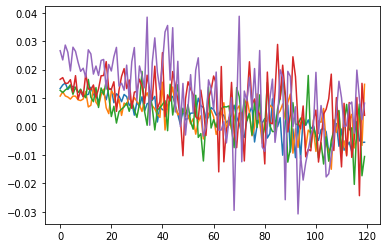

In [131]:
plt.plot(simulated_rates)

In [123]:
from scipy.stats import kstest, norm
for i in euribor.iloc[:,1:].columns:
    fit_params = norm.fit(euribor[i])
    # Perform the KS test for a normal distribution
    #statistic, p_value = kstest(simulated_rates[i], 'norm', fit_params)
    statistic, p_value = kstest(simulated_rates[i], 'norm', fit_params)

    # Print the results
    print("KS Statistic:", statistic)
    print("P-value:", p_value)

KS Statistic: 0.4314037867339692
P-value: 8.254242596888259e-21
KS Statistic: 0.42922631100133446
P-value: 1.352875417790242e-20
KS Statistic: 0.3692780457253245
P-value: 3.4610326022666006e-15
KS Statistic: 0.3654515821125311
P-value: 7.122046795055132e-15
KS Statistic: 0.286246467639231
P-value: 3.385446910985431e-09


In [124]:
statistic, p_value = kstest(simulated_rates['6M'], euribor['6M'])
print("KS Statistic:", statistic)
print("P-value:", p_value)

KS Statistic: 0.4666666666666667
P-value: 3.564085982600102e-12


R0 = euribor.iloc[0,1:]
alpha = ah_list
sigma = sh_list
r = rh_list
T=10

R0 = euribor.iloc[0,1:]
T=10
def MCsimulateVasicek(a, r, sigma, dt, T, Rt0):
    nrTrials = int(T / dt)
    interestRate = np.zeros((nrTrials, 1))
    interestRate[0] = Rt0
    
    # Simulating the spot rate up to nrTrials number of times
    for i in range(1, nrTrials):
        interestRate[i] = interestRate[i - 1] + a * (r - interestRate[i - 1]) * dt + np.sqrt(sigma) * np.sqrt(dt) * np.random.randn()
    
    return interestRate


R0 = train_data.iloc[-1,1:]
T=10
def MCsimulateVasicek(a, r, sigma, dt, T, Rt0):
    nrTrials = int(T / dt)
    interestRate = np.zeros((nrTrials, 1))
    interestRate[0] = Rt0
    
    # Simulating the spot rate up to nrTrials number of times
    for i in range(1, nrTrials):
        interestRate[i] = interestRate[i - 1] + a * (r - interestRate[i - 1]) * dt + np.sqrt(sigma) * np.sqrt(dt) * np.random.randn()
    
    return interestRate

# Initialize empty lists
list_6M = []
list_1Y = []
list_3Y = []
list_5Y = []
list_10Y = []

# Append interest rates to the respective lists
list_6M.extend(MCsimulateVasicek(alpha[0], r[0], sigma[0], 1/12, T, R0[0]))
list_1Y.extend(MCsimulateVasicek(alpha[1], r[1], sigma[1], 1/12, T, R0[1]))
list_3Y.extend(MCsimulateVasicek(alpha[2], r[2], sigma[2], 1/12, T, R0[2]))
list_5Y.extend(MCsimulateVasicek(alpha[3], r[3], sigma[3], 1/12, T, R0[3]))
list_10Y.extend(MCsimulateVasicek(alpha[4], r[4], sigma[4], 1/12, T, R0[4]))

# Create DataFrame
sim = pd.DataFrame({
    '6M': list_6M,
    '1Y': list_1Y,
    '3Y': list_3Y,
    '5Y': list_5Y,
    '10Y': list_10Y
}) 

# Apply np.squeeze to each element of the DataFrame to remove the brackets
sim = sim.applymap(lambda x: np.squeeze(x))

# Print DataFrame
print(sim)

plt.plot(sim)
plt.show()
plt.plot(euribor.iloc[:,1:])
plt.show()

mean_squared_error(sim,euribor.iloc[:,1:])

In [63]:
statistic, p_value = kstest(sim['6M'], euribor['6M'])
print("KS Statistic:", statistic)
print("P-value:", p_value)

KS Statistic: 0.5083333333333333
P-value: 1.7747782240842483e-14
